# Collaborative Filtering Netflix
Notebook that contains the code for collaborative filtering for the Netflix dataset.

In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb

### Import the Data

In [3]:
netflix_rating_df = pd.read_csv('data_folder/small_data.csv', sep=',', names=['movie_id', 'user_id','rating','date'])

In [4]:
split_value = int(len(netflix_rating_df) * 0.80)
train = netflix_rating_df[:split_value]
test = netflix_rating_df[split_value:]

### Basic EDA on Dataset

<ipython-input-5-2fbdccad9b81>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


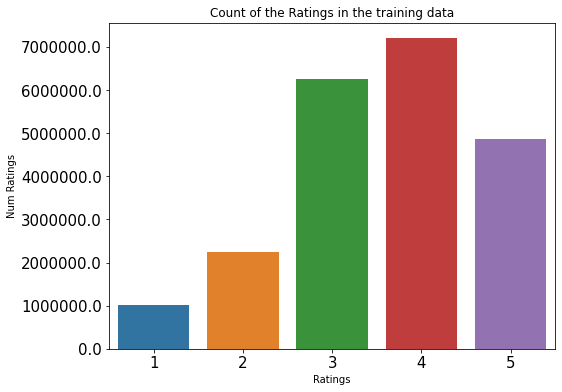

In [5]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(x="rating", data=train)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count of the Ratings in the training data")
plt.xlabel("Ratings")
plt.ylabel("Num Ratings")
plt.show()

### Create the Sparse Matrix
Create the sparse matrix for the training and testing data

In [6]:
def sparse_matrix(df):
    return sparse.csr_matrix((df.rating, (df.user_id, df.movie_id)))

In [7]:
train_sparse = sparse_matrix(train)
test_sparse = sparse_matrix(test)

### Get the Average Ratings for users and movies

In [8]:
def avg_rating(sparse_matrix, is_user=True):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [9]:
average_rating_user = avg_rating(train_sparse)
avg_rating_movie = avg_rating(train_sparse, False)

In [10]:
movie_titles_df = pd.read_csv("data_folder/movie_titles.csv", sep = ",", header = None, names=['movie_id', 'year_of_release', 'movie_title'], index_col = "movie_id", encoding = "iso8859_2")

In [11]:
def sparse_sample_matrix(sparseMatrix, num_users, num_movies):
    users, movies, ratings = sparse.find(sparseMatrix)
    unique_users = np.unique(users)
    unique_movies = np.unique(movies)
    
    userS = np.random.choice(unique_users, num_users, replace = False)
    movieS = np.random.choice(unique_movies, num_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    
    return sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(userS)+1, max(movieS)+1))

In [12]:
train_sparse_sample = sparse_sample_matrix(train_sparse, 400, 40)
test_sparse_sample = sparse_sample_matrix(test_sparse, 200, 20)

### Engineer the new Similarity Features

In [15]:
def similarity_features(ss_matrix):
    global_avg_rating = avg_rating(ss_matrix, False)
    global_avg_users = avg_rating(ss_matrix, True)
    global_avg_movies = avg_rating(ss_matrix, False)
    
    users, movies, ratings = sparse.find(ss_matrix)
    new_features_csv_file = open("data_folder/new_features.csv", mode = "w")
    
    for user, movie, rating in zip(users, movies, ratings):
        sim = []
        sim.append(user)
        sim.append(movie)
        sim.append(ss_matrix.sum()/ss_matrix.count_nonzero())
        
        u_ratings = ss_matrix[np.argsort(-cosine_similarity(ss_matrix[user], ss_matrix).ravel())[1:], movie].toarray().ravel()
        top_user = list(u_ratings[u_ratings != 0][:5])
        top_user.extend([global_avg_rating[movie]] * (5-len(u_ratings)))
        sim.extend(top_user)
        
        m_ratings = ss_matrix[user, np.argsort(-cosine_similarity(np.transpose(ss_matrix[:,movie]), np.transpose(ss_matrix)).ravel())[1:]].toarray().ravel()
        top_movie = list(m_ratings[m_ratings != 0][:5])
        top_movie.extend([global_avg_users[user]] * (5-len(top_movie)))
        sim.extend(top_movie)
        
        sim.append(global_avg_users[user])
        sim.append(global_avg_movies[movie])
        sim.append(rating)
        
        new_features_csv_file.write(",".join(map(str, sim)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('data_folder/new_features.csv', names = ["user_id", "movie_id", "global_average",
                                                               "user1", "user2", "user3", "user4", "user5", 
                                                               "movie1", "movie2", "movie3", "movie4", 
                                                               "movie5", "avg_user", "avg_movie", "rating"])
    return new_features_df

In [16]:
train_features = similarity_features(train_sparse_sample)
train_features.replace([np.inf, -np.inf], np.nan, inplace=True)
train_features.dropna(inplace=True)

In [17]:
test_features = similarity_features(test_sparse_sample)
test_features.replace([np.inf, -np.inf], np.nan, inplace=True)
test_features.dropna(inplace=True)

In [18]:
train_features = train_features.reset_index()
test_features = test_features.reset_index()

In [19]:
x_train = train_features.drop(["user_id", "movie_id", "rating"], axis = 1)
x_test = test_features.drop(["user_id", "movie_id", "rating"], axis = 1)
y_train = train_features["rating"]
y_test = test_features["rating"]

In [20]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[01:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=False, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
y_pred_test = clf.predict(x_test)

In [22]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

RMSE: 0.6245797912930791
